In [1]:
import os
import re
import collections
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from random import sample

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]
handled_text = quotes

In [3]:
#all unique characters go here
tokens = list(set(''.join(handled_text)))

num_tokens = len(tokens)
print ('num_tokens =', num_tokens)

num_tokens = 88


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print(handled_text[3])
print(to_matrix(handled_text[3:5], token_to_id)[0])
print(len(handled_text[3]))

 Organizing is what you do before you do something, so that when you do it, it is not all mixed up.
[87 64 13 47 30 39 28 42 28 39 47 87 28 49 87 12 51 30 36 87 68  0 66 87
 57  0 87 27 60  5  0 13 60 87 68  0 66 87 57  0 87 49  0 53 60 36 51 28
 39 47 11 87 49  0 87 36 51 30 36 87 12 51 60 39 87 68  0 66 87 57  0 87
 28 36 11 87 28 36 87 28 49 87 39  0 36 87 30 35 35 87 53 28 52 60 57 87
 66 65 55]
99


In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
from IPython.display import clear_output
from random import sample

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, hidden_size=256):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.LSTM = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h=None, c=None):
        if h is not None and c is not None:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x), (h, c))
        else:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x))
            
        next_logits = self.hid_to_logits(out_put)
        next_logp = F.log_softmax(next_logits, dim=-1)
        
        return next_logp, h_new, c_new

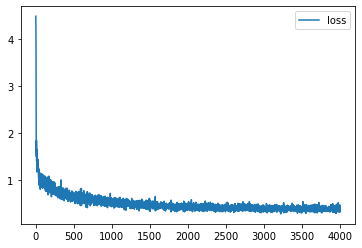

In [10]:
MAX_LENGTH = max(map(len, handled_text))

model = CharLSTMLoop()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
history = []

best_loss = 6

best_model_wts = copy.deepcopy(model.state_dict())

for i in range(4000):
    batch_ix = to_matrix(sample(handled_text, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq, _, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    if loss < best_loss:
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 20 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [11]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [12]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    
    h_t = None
    c_t = None
    if len(seed_phrase) > 1:
        _, h_t, c_t = model.forward(x_sequence[:, :-1], h_t)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, h_t, c_t = model.forward(x_sequence[:, -1].unsqueeze(-1), h_t, c_t)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence[0].data.numpy()])


model = model.to('cpu')
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.6))

 The early ones were something else is the post of the prool of the end.                                                                                                                                                                                                                                                                                                                                                     
 I'm a problem in an all the small from a blessing stuff, and I'll love the man who has an alled that because they do not expect the people are country in the mind of lives that are truth in the time to think that I want to have to talk the same things and some single process.                                                                                                                                        
 I have never really a sense that are a real and eventield that the ones that they get a book and the one should play the properity. The state is not going to be a big serv

In [13]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' Humanity is', temperature=0.6))

 Humanity is the post the enemy that you feel personally stream of the world of many of the fire of respection to make a school to the leaves and defend the education, and the people who seem to make the sound of having measured and person in a black to have the same things that we have to be involved with the newspation of selling someone who say them about anything that it can feel the characters of writing.
 Humanity is the actual belief.                                                                                                                                                                                                                                                                                                                                                                                              
 Humanity is that some universe is to possible to put the world and that doesn't have to do it that a lot of people.                                                        

In [14]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' Find', temperature=0.6))

 Finds when a world means the punit on the vigue or being his mind in the same time.                                                                                                                                                                                                                                                                                                                                         
 Find the power of hove is the world in a story.                                                                                                                                                                                                                                                                                                                                                                             
 Finding my reliarity and my people like way to come to the sense.                                                                                                          

In [15]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' This scene is', temperature=0.6))

 This scene is not a good thing than a hus of the most players and property to people who should never think you have to accept the sound of the news passion more.                                                                                                                                                                                                                                                          
 This scene is the possible bigger develop in a mother of the capazity of the possible things of people like.                                                                                                                                                                                                                                                                                                                
 This scene is not the respect of joy.                                                                                                                                      

In [17]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' People', temperature=0.6))

 People know what I was my believed to do it.                                                                                                                                                                                                                                                                                                                                                                                
 People are proved the hardest things that were too dome religion of their own says to find the process.                                                                                                                                                                                                                                                                                                                     
 People write the sense of the character along the support the people and change of the people that remembered they are the color they are no reason that it doesn't be much

In [18]:
torch.save(model, 'Quotes_generation.pt')